# Import libraries and functions

In [ ]:
import msprime
import tskit
import random
import numpy as np
import random
import sklearn

import pandas as pd
from numpy import linalg as LNG 
from random import randint, randrange


from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report 


import seaborn
import matplotlib
from matplotlib import pyplot as plt

import math
import scipy
import scipy.optimize as optimize
from scipy.optimize import minimize


# Make simulations

In [5]:
# --- Demographic model ---

def history_of_mexicans(gen_time, len_seq, rr,mu, n_e, t,  n, rand_sd, n_neand, n_mexicans, t_neand_samples ):
    
        
    n_ANC, n_ND, n_AMH, n_OOF,n_AF, n_EU, n_AS, n_NA, n_MX = n_e
    t_NEAND_migration, t_NEAND_AMH, t_OOF_AF, t_AS_EU_split, t_AS_NA_split, t_MEX_admix = t
    
    demography = msprime.Demography()
    
    
    demography.add_population(name="AF", initial_size=n_AF)
    demography.add_population(name="EU", initial_size=n_EU)
    demography.add_population(name="NA", initial_size=n_NA)
    demography.add_population(name="MX", initial_size=n_MX*math.exp(0.05*t_MEX_admix), growth_rate = 0.05)
    
    demography.add_population(name="AS", initial_size=n_AS)    

    demography.add_population(name="OOF", initial_size=n_OOF)
    demography.add_population(name="AMH", initial_size=n_AMH)
    demography.add_population(name="NEAND", initial_size=n_ND)
    demography.add_population(name="ANCES", initial_size=n_ANC)  #common population for Neanderthal and AMH 




    demography.add_admixture(time= t_MEX_admix , derived="MX", ancestral=["AF", "EU", "NA"], proportions=[0.05, 0.5, 0.45])
    demography.add_population_split(time = t_AS_NA_split, derived=["NA"], ancestral="AS")
    demography.add_population_split(time = t_AS_EU_split, derived=["EU", "AS"], ancestral="OOF")    

    demography.add_mass_migration(time=t_NEAND_migration, source='OOF', dest='NEAND', proportion=0.05)
    demography.add_population_split(time = t_OOF_AF, derived=["AF", "OOF"], ancestral="AMH")
    demography.add_population_split(time = t_NEAND_AMH, derived=["AMH", "NEAND"], ancestral="ANCES")

 #   print(demography.debug())
    TS = msprime.sim_ancestry(
        samples=
        [       
                msprime.SampleSet(n_mexicans, ploidy=1, population='MX'),
                msprime.SampleSet(n, ploidy=1, population='EU'), 
                msprime.SampleSet(n, ploidy=1, population='NA'),
                msprime.SampleSet(n, ploidy=1, population='AF'),
                msprime.SampleSet(n_neand, ploidy=1, population='NEAND', time = t_neand_samples)          
               
        ],
    
        ploidy=1,    
        sequence_length=len_seq,
        recombination_rate=rr, 
        demography=demography,
        record_migrations=True, 
        random_seed=54382129,
        num_replicates = 20
                                
    )
    
    # Due to the small percentage of Af and RANDOM we coud get Mex individual without this proportion. 
    #c'est la vie. To prevent it we do procedure with replication index.
    prop = []
    for replicate_index, ts in enumerate(TS):
        INDIVIDUAL = -1
        for i in ts.tables.migrations:
            if i.time == t_MEX_admix and i.dest == 0 and i.node<40:
                INDIVIDUAL = i.node
                
            if INDIVIDUAL != -1: 
                
                proportions = np.array([0,  0, 0]) #proportions Af, Eu, NA
                for i in ts.tables.migrations:
                    if i.time == t_MEX_admix and i.node == INDIVIDUAL:
                        if i.dest == 0:
                            proportions[0] += i.right - i.left
                        if i.dest == 1:
                            proportions[1] += i.right - i.left
                        if i.dest == 2:
                            proportions[2] += i.right - i.left
                proportions = proportions / sum(proportions)
                break
        if INDIVIDUAL != -1:
            prop.append([proportions, ts])

    
    
    s = 1
    for i in range(len(prop)):
        if prop[i][ 0][0] < 0.1 and prop[i][ 0][0] > 0.01 and prop[i][0][2] > 0.2 and prop[i][0][1] > 0.3:
            s = prop[i][0][0]
            ts_af = prop[i][1]
            proportions = prop[i][0]
            break
    print('We generate mexican individual with Af-Eu-NA proportions = ', proportions)
    
    ts_af = msprime.sim_mutations(ts_af, rate=mu, random_seed=rand_sd)
    
    return ts_af, proportions

# Define true ancestry from simulations

In [6]:
#несколько вспомогательных функций
def connected(m):
    for i in range(len(m)-1):
        if m[i][1] == m[i+1][0]:
            return True
    return False
        
def remove_one(m):
    mas = m
    while connected(mas) == True:
        for i in range(len(mas)-1):
            if mas[i][1] == mas[i+1][0]:
                mas[i][1] = mas[i+1][1]
                mas.pop(i+1)
                break
    return mas


#Вход: ts, название популяции, индивид(которого мы препарируем), время предка
def get_migrating_tracts_ind(ts, pop_name, ind, T_anc):
    
    pop=-1
    for i in ts.populations():
        if i.metadata['name']==pop_name:
            pop=i.id
    
    mig = ts.tables.migrations
    migration_int = []

    for tree in ts.trees():  #перебираем все деревья. Как известно, каждому дереву отвечает участок днк  
        anc_node = ind #выбираем мексиканца
        while tree.time( tree.parent(anc_node) ) <= T_anc : #идем в прошлое до вершины anc_node по предкам нашего мексиканца, пока не наткнемся на миграцию 
            anc_node = tree.parent(anc_node)
        migs = np.where(mig.node == anc_node)[0] #выбирем все строки, соответствующие заданному узлу

        #идем по таблице миграций с anc_node и проверяем, чтобы миграции попадали в тот самый участок днк
        for i in migs:

            stroka = mig[i]
            if stroka.time == T_anc and stroka.dest == pop and tree.interval.left >= stroka.left and tree.interval.right <= stroka.right:
                migration_int.append([tree.interval.left, tree.interval.right])

    migration_int2 = []
    for i in range(len(migration_int)):
        if migration_int[i][0] != migration_int[i][1]:
            migration_int2.append(migration_int[i])
    migration_int = migration_int2
    
    mi = remove_one(migration_int)
    mi.sort()  

    return mi  




In [7]:
def color_states(cut,tractsND, tractsEU, tractsAS, tractsAF):
    
    
    # лежит ли точка p в интервале i?
    def point_in_interval(p, interval):
        if p >= interval[0] and p <= interval[1]:
            return True
        else:
            return False
    
    state_seq = np.array([-1]*int(seq_length/cut))
    for t in range(0, int(seq_length), cut):



        f=False
        for j in tractsAF:
            if point_in_interval(t, j)==True:
                f= True
        if f==True:
            state_seq[int(t/cut)]=4

        f=False
        for j in tractsEU:
            if point_in_interval(t, j)==True:
                f= True
        if f==True :
            state_seq[int(t/cut)]=0



        f=False
        for j in tractsAS:
            if point_in_interval(t, j)==True:
                f= True
        if f==True :
            state_seq[int(t/cut)]=2

        f=False
        for j in tractsND:
            if point_in_interval(t, j)==True:
                f= True
        if f==True and state_seq[int(t/cut)]==0:
            state_seq[int(t/cut)]=1
        if f==True and state_seq[int(t/cut)]==2:
            state_seq[int(t/cut)]=3
    return state_seq





# Create sequences of observations

In [8]:
# Creates the sequence of observations.
def createSeqObsS(ts,cut,ind,pop) -> list:
    tables = ts.dump_tables()
    nodes = tables.nodes
    seq = np.zeros(int(ts.sequence_length/cut),dtype=int)  #The list which will contain the result of our function.
    pop_id = [p.id for p in ts.populations() if p.metadata['name']==pop][0] 
    start=-1
    end=-1
    for i in range(len(nodes)):
        if nodes[i].population==pop_id and start ==-1:
            start = i
        if nodes[i].population!=pop_id and start !=-1:
            end = i-1
            break
    
    for v in ts.variants():
        i=int(v.site.position/cut)
        c = False
        x=0
        while x < end: 
            if(nodes[x].individual==ind): # Check is this position corresponds to individual 'ind'
                b=v.genotypes[x]
                
                x=start
            elif(nodes[x].population==pop_id): # Check is this position corresponds to an individual in 'pop'
                
                if(v.genotypes[x]==b): 
                    c = True # The mutation found in 'ind' is also present in the population 'pop' 
                    x = end # We can skip all the remaining individuals
            x=x+1                     
        if not c : # If c is False it means that the mutation in 'ind' has not been found in the population 'pop' 
            seq[i]=seq[i]+1
    return seq

#функция, наблюдения для неандертальцев в зависимости от их количества
def createSeqObs_neand(ts,cut, ind, n_neanderthals, n_mexicans, n, n_neand ):
    #если в массиве есть повторяющиеся значения, то возвращает True, иначе False
    def repetitions(arr):

        for elem in arr:
            if arr.count(elem) > 1:
                return True
        return False
    inx = [randrange(3*n+n_mexicans, 3*n+n_mexicans+n_neand) for i in range(n_neanderthals)]
    
    while  repetitions(inx) is True:
        inx = [randrange(3*n+n_mexicans, 3*n+n_mexicans+n_neand) for i in range(n_neanderthals)]
        
    inx.sort()
#    print(inx)    
    seq = np.zeros(int(ts.sequence_length/cut),dtype=int)  #The list which will contain the result of our function.
    
    for v in ts.variants():
        i=int(v.site.position/cut)
        
        flag = False
        for j in inx:
            if abs(v.genotypes[j]-v.genotypes[ind])==0:
                flag = True
                break
                
            
        if flag == False:
            seq[i] += 1
              
    return seq

#функция, наблюдения
def createSeqObs_main(ts,cut,pop, ind,  n_mexicans, n, n_ref_pop ):
    
    inx = []
    if pop == 'EU':
        inx=[i for i in range(n_mexicans, n_mexicans+n_ref_pop)]
    if pop == 'NA':
        inx = [i for i in range(n_mexicans+n, n+n_mexicans +n_ref_pop)]
    if pop == 'AF':
        inx = [i for i in range(n_mexicans+2*n, 2*n+n_mexicans+n_ref_pop)]        

    seq = np.zeros(int(ts.sequence_length/cut),dtype=int)    
    for v in ts.variants():
        i=int(v.site.position/cut)
        
        flag = False
        for j in inx:
            if abs(v.genotypes[j]-v.genotypes[ind])==0:
                flag = True
                break
                
            
        if flag == False:
            seq[i] += 1
              
    return seq



# Some useful functions

In [9]:
#список нодов, в которых мексиканцы с Африканской компонентой
def create_mex_with_af_list(ts, t, n_obs_mex):
    
    lst = []
    for i in ts.tables.migrations:
        if i.time == t[5] and i.dest == 0 and i.node< n_obs_mex:
            lst.append(i.node)
#        if len(list(set(lst))) >=10:
#            break
    return list(set(lst))

# Some functions which could be useful to save data

In [10]:
#we need to save  observation sequence  for Mexicans with african component
def save_mex_obs(ts, cut, t, n_obs_mex, num_mex):
    
    #список нодов, в которых мексиканцы с Африканской компонентой
    def create_mex_with_af_list(ts):
        lst = []
        for i in ts.tables.migrations:
            if i.time == t[5] and i.dest == 0 and i.node< n_obs_mex:
                lst.append(i.node)
            if len(list(set(lst))) >=10:
                break
        return list(set(lst))
    
    
    lst = create_mex_with_af_list(ts)
    
    print(lst)
    
#    n_mex=len(lst)
    if len(lst) < n_obs_mex:
        n_mex = len(lst)
    else:
        n_mex=n_obs_mex
        
    n_mex = num_mex
    
    for i_mex in range(n_mex):
        filename='nd.readme.'+str(i_mex)+'.txt'
        ind_number = int(lst[i_mex])


        
        seqNd = createSeqObsS(ts, cut,ind_number,"NEAND")
        seqEu = createSeqObsS(ts, cut,ind_number,"EU")
        seqNa = createSeqObsS(ts, cut,ind_number,"NA")
        seqAf = createSeqObsS(ts, cut,ind_number,"AF")
        seq = np.column_stack((seqEu,seqNa,seqAf,seqNd))

        with open(filename, 'w') as f:
            for j in seq:
                f.write(str(j[0])+' '+str(j[1])+' '+str(j[2])+' '+str(j[3])+'\n')
        print('Wrote observations for Mexican', i_mex)
        
        
def write_all_data_for_single_mex(ts, ind_number, cut,t):    
    
    tractsND = get_migrating_tracts_ind(ts, "NEAND", ind_number, t[0])
    tractsEU = get_migrating_tracts_ind(ts,"EU", ind_number, t[5])
    tractsAS = get_migrating_tracts_ind(ts,"NA", ind_number, t[5])
    tractsAF =get_migrating_tracts_ind(ts,"AF", ind_number, t[5])

    
    seqNd = createSeqObsS(ts, cut,ind_number,"NEAND")
    seqEu = createSeqObsS(ts, cut,ind_number,"EU")
    seqNa = createSeqObsS(ts, cut,ind_number,"NA")
    seqAf = createSeqObsS(ts, cut,ind_number,"AF")
    seq = np.column_stack((seqEu,seqNa,seqAf,seqNd))

    number_states = [max(seqNd), max(seqEu), max(seqNa), max(seqAf)]
    filename='nd.full.mex.txt'
    with open(filename, 'w') as f:
        f.write('['+str(t[0])+', '+str(t[1])+', '+str(t[2])+', '+str(t[3])+', '+str(t[4])+', '+str(t[5])+']\n')
        f.write(str(GEN_time)+'\n')
        f.write(str(len_sequence)+'\n')
        f.write(str(proportions)+'\n')
        f.write(str(cut)+'\n')
        

        f.write(str(tractsND))
        f.write('\n')
        f.write(str(tractsEU))
        f.write('\n')
        f.write(str(tractsAS))
        f.write('\n') 
        f.write(str(tractsAF))
        f.write('\n')
        for i in seq:
            f.write(str(i[0])+' '+str(i[1])+' '+str(i[2])+' '+str(i[3])+'\n')

            


# HMM: Transition matrix, emission probabilities, Viterbi

In [151]:
#Ti: Introgression of Nd
#Tmex: Time in Mexico
def initA(Ti,Tmex,r,L,a,b,c) -> np.array:
    A = np.zeros((5,5))
    Ti=2*Ti
    Tmex=2*Tmex
    
    d=1-a-b
    A[0][1]=Ti*r*L*a*c
    A[0][2]=Tmex*r*L*b*(1-c)
    A[0][3]=Tmex*r*L*b*c
    A[0][4]=Tmex*r*L*d
    A[0][0]=1-A[0][1]-A[0][2]-A[0][3]-A[0][4]
 
    A[1][0]=Ti*r*L*a*(1-c)
    A[1][2]=Tmex*r*L*b*(1-c)
    A[1][3]=Tmex*r*L*b*c
    A[1][4]=Tmex*r*L*d
    A[1][1]=1-A[1][0]-A[1][2]-A[1][3]-A[1][4]
    
    A[2][0]=Tmex*r*L*a*(1-c)
    A[2][1]=Tmex*r*L*a*c
    A[2][3]=Ti*r*L*b*c
    A[2][4]=Tmex*r*L*d
    A[2][2]=1-A[2][0]-A[2][1]-A[2][3]-A[2][4]
    
    A[3][0]=Tmex*r*L*a*(1-c)
    A[3][1]=Tmex*r*L*a*c
    A[3][2]=Ti*r*L*b*(1-c)
    A[3][4]=Tmex*r*L*d
    A[3][3]=1-A[3][0]-A[3][1]-A[3][2]-A[3][4]

    A[4][0]=Tmex*r*L*a*(1-c)
    A[4][1]=Tmex*r*L*a*c
    A[4][2]=Tmex*r*L*b*(1-c)
    A[4][3]=Tmex*r*L*b*c
    A[4][4]=1-A[4][0]-A[4][1]-A[4][2]-A[4][3]
    
    return A

#Ti: Introgression of Nd
#Tea: Split between Asia and Europe
#Tmex: Time of migration to Mexixo
#Taf: Time out of Africa
#Tn: Time of Split between Nd and Sapiens

def initB(m,L, lmbd, n_st) -> np.array: 
    
    B = np.empty(shape=(5,n_st,n_st,n_st,n_st))
    meani = lmbd[0]
    meann = lmbd[1]
    meanea =lmbd[3]
    meanmex =lmbd[4]
    meanaf = lmbd[2]


    
    Pi = np.empty(n_st)
    Pea = np.empty(n_st)
    Pmex = np.empty(n_st)
    Paf=np.empty(n_st)
    Pn=np.empty(n_st)

    
    Pi[0]=np.exp(-meani)
    Pea[0]=np.exp(-meanea)
    Pmex[0]=np.exp(-meanmex)
    Paf[0]=np.exp(-meanaf)
    Pn[0]=np.exp(-meann)
    
    sumi=0
    sumea=0
    summex=0
    sumaf=0
    sumn=0
    
    for i in range(1,n_st):
        Pi[i]=Pi[i-1]*meani/i
        Pea[i]=Pea[i-1]*meanea/i
        Pmex[i]=Pmex[i-1]*meanmex/i
        Paf[i]=Paf[i-1]*meanaf/i
        Pn[i]=Pn[i-1]*meann/i
        
        sumi=sumi+Pi[i]
        sumea=sumea+Pea[i]
        summex=summex+Pmex[i]
        sumaf=sumaf+Paf[i]
        sumn=sumn+Pn[i]

    Pea[0]=1-sumea
    Pi[0]=1-sumi
    Pmex[0]=1-summex
    Paf[0]=1-sumaf
    Pn[0]=1-sumn
    
    for i in range(n_st): 
        for j in range(n_st):
            for k in range(n_st):
                for t in range(n_st):
                    B[0][i][j][k][t]=Pmex[i]*Pea[j]*Paf[k]*Pn[t]
                    B[1][i][j][k][t]=Pmex[i]*Pea[j]*Pn[k]*Pi[t]
                    B[2][i][j][k][t]=Pea[i]*Pmex[j]*Paf[k]*Pn[t]
                    B[3][i][j][k][t]=Pea[i]*Pmex[j]*Pn[k]*Pi[t]
                    B[4][i][j][k][t]=Paf[i]*Paf[j]*Pmex[k]*Pn[t]    

    return B




In [12]:

# forward-algo
def alpha_scaled_opt(a,b, o, p):
    
    c = np.zeros(int(seq_length/cut)) #scaling factors, которые как раз позволяют не обнулиться
    
    alpha = np.zeros((N, int(seq_length/cut)))
    alpha[:, 0] = b[:, o[0][0],o[0][1],o[0][2],o[0][3]] * p
    
    c[0] = 1 / sum(alpha[:, 0])
    alpha[:, 0] = alpha[:, 0] / sum(alpha[:, 0])
    
    
    

    for t in range(1, int(seq_length/cut)):   
        
        for i in range(0, N):
            alpha[i, t] = np.dot(alpha[:, t-1],a[:,i]) * b[i, o[t][0],o[t][1],o[t][2],o[t][3]] 
            
        c[t] = 1 / sum(alpha[:,t]) #сохраняем множители        
        alpha[:, t] = alpha[:, t] / sum(alpha[:,t])     
        
    return alpha, c

# Backward procedure. Scaled case.
def beta_scaled_opt(a,b, o, scaling_factors):
    
    beta = np.zeros((N, int(seq_length/cut)))
    
    length = int(seq_length/cut)
    beta[:, length - 1] = np.ones(N)*scaling_factors[length-1] 
    

    for t in range(int(seq_length/cut)-2,-1,-1):             
        for i in range(0, N):             
            for l in range(0, N):
                beta[i, t] += a[i, l] * b[l, o[t+1][0],o[t+1][1],o[t+1][2],o[t+1][3]] * beta[l, t+1]
                
        beta[:, t] = beta[:, t] * scaling_factors[t]

    return beta 

# gamma matrix
def def_gamma(alpha, beta):
        
    gamma = np.zeros((N,len(alpha[0])))
    for m in range(0, len(alpha[0])):
        denom = sum(alpha[:, m]*beta[:,m])
        
        for i in range(0,N):
            gamma[i, m] = (alpha[i, m] * beta[i, m]) / denom
    return gamma


# ksi[i, j, t]
def def_ksi( a, b, o, alpha, beta):
    
    M = len(o)
    ksi = np.zeros((N, N, M-1))
    
    for t in range(0, M-1):
        
        denom = 0
        for i in range(0, N):
            for j in range(0, N):
                denom += alpha[i, t] * a[i, j] * b[j, o[t+1][0],o[t+1][1],o[t+1][2],o[t+1][3]] * beta[j, t+1]
                
        
        for i in range(0, N):
            for j in range(0, N):
                ksi[i, j, t] = (alpha[i, t]*a[i, j]*b[j, o[t+1][0],o[t+1][1],o[t+1][2],o[t+1][3]] * beta[j, t+1]) / denom
    
    return ksi

In [13]:
def viterbi(V, initial_distribution, a, b):
    
    T = len(V)
    M = a.shape[0]
 
    omega = np.zeros((T, M))
    omega[0, :] = np.log(initial_distribution * b[:, V[0][0],V[0][1],V[0][2],V[0][3]])
 
    prev = np.zeros((T - 1, M))
 
    for t in range(1, T):
        for j in range(M):
            # Same as Forward Probability
            probability = omega[t - 1] + np.log(a[:, j]) + np.log(b[j, V[t][0], V[t][1], V[t][2],V[t][3]])
 
            # This is our most probable state given previous state at time t (1)
            prev[t - 1, j] = np.argmax(probability)
 
            # This is the probability of the most probable state (2)
            omega[t, j] = np.max(probability)
 
    # Path Array
    S = np.zeros(T)
 
    # Find the most probable last hidden state
    last_state = np.argmax(omega[T - 1, :])
 
    S[0] = last_state
 
    backtrack_index = 1
    for i in range(T - 2, -1, -1):
        S[backtrack_index] = prev[i, int(last_state)]
        last_state = prev[i, int(last_state)]
        backtrack_index += 1
 
    # Flip the path array since we were backtracking
    S = np.flip(S, axis=0)
 
    # Convert numeric values to actual hidden states
 
    result = []
    for s in S:
        if s == 0:
            result.append(0)
        elif s == 1:
            result.append(1)
        elif s == 2:
            result.append(2)
        elif s == 3:
            result.append(3)
        elif s == 4:
            result.append(4)

    return result



# HMM post-processing

In [14]:

def get_HMM_tracts(seq):
    migrating_tracts = []
    for i in range(5):
        migrating_tracts.append([])
    start=0
    for i in range(1,len(seq)):
        if seq[i]!=seq[i-1]:
            migrating_tracts[seq[i-1]].append([start,i-1])
            start=i
    migrating_tracts[seq[len(seq)-1]].append([start,len(seq)-1])
    return migrating_tracts



def tracts_to_states(len_seq, tractsND,tractsEU,tractsAS,tractsAF):
    seqTrue=np.zeros(len_seq, dtype=int)
    for t in tractsND:
        for i in range(t[0],t[1]):
            seqTrue[i]=1
    for t in tractsAS:
        for i in range(t[0],t[1]):
            if seqTrue[i]==0:
                seqTrue[i]=2
            else:
                seqTrue[i]=3
    for t in tractsAF:
        for i in range(t[0],t[1]):
            seqTrue[i]=4    
    return seqTrue

def clean_tracts(tractInit, CUT):
    tract = np.copy(tractInit)
    tract = tract/CUT
    tract=tract.astype(int)
    flag = True
    while(flag):
        flag=False
        for i in range(len(tract)):
            for j in range(len(tract)):
                if not flag and tract[i,0]==tract[j,1]:
                    tract[j,1]=tract[i,1]
                    tract = np.delete(tract,i,0)
                    flag=True
    flag = True
    while(flag):
        flag=False
        for i in range(len(tract)):
            for j in range(i+1,len(tract)):
                if tract[i,0]>tract[j,0]:
                    save0=tract[i,0]
                    save1=tract[i,1]
                    tract[i,0]=tract[j,0]
                    tract[i,1]=tract[j,1]
                    tract[j,0]=save0
                    tract[j,1]=save1
                    flag=True
    return tract

def tracts_to_states_after_vit(len_seq, tracts):
    seqTrue=np.zeros(len_seq, dtype=int)
    for j in range(5):
        
        for t in tracts[j]:
            for i in range(t[0],t[1]):
                seqTrue[i]=j
 
    return seqTrue

# EM algorithm one observation

In [132]:
def new_lambda_mex(o, gamma):
    lmbd=0
    
    for t in range(1, len(o), 1):
        lmbd += o[t, 0] * ( gamma[0, t] + gamma[1, t]) + o[t, 1] * (gamma[2, t] + gamma[3, t]) + o[t, 2]  * gamma[4, t]     
        
    return lmbd/(len(o)-1)


def new_lambda_n(o, gamma):
    lmbd = 0
    
    for t in range(1, len(o), 1):
        lmbd += o[t, 3] * ( gamma[0, t] + gamma[2, t]+gamma[4, t]) + o[t, 2] * (gamma[1, t] + gamma[3, t]) 
        
    return lmbd/ (len(o)-1)

def new_lambda_i(o, gamma):
    nom=0
    denom=0
    
    for t in range(1, len(o), 1):   
        nom += o[t, 3] * (gamma[1, t] + gamma[3, t])
        denom += gamma[1, t] + gamma[3, t]
        
    return nom / denom

def new_lambda_af(o, gamma):
    nom, denom = 0, 0
    
    for t in range(1, len(o), 1):   
        nom += o[t, 2] * ( gamma[0, t] + gamma[2, t]) + (o[t, 0] + o[t, 1]) * gamma[4, t]
        denom += gamma[0, t] + gamma[2, t]+ 2 * gamma[4, t]    
    
    return nom/ denom

def new_lambda_ea(o, gamma):
    nom, denom = 0, 0
    for t in range(1, len(o), 1):  
        nom += o[t, 1] * ( gamma[0, t] + gamma[1, t]) + o[t, 0]  * (gamma[2, t]+gamma[3,t])
        denom += gamma[0, t] + gamma[1, t]+  gamma[2, t] + gamma[3, t]
    
    return nom/ denom

def new_a_ij(gamma, ksi):
    a = np.zeros((5, 5 ))
    nom = 0
    denom = 0
    
    
    for i in range(5):
        for j in range(5):
            for t in range(len(gamma[0])-1):
                nom += ksi[i,j,t]
                denom += gamma[i, t]
            a[i,j] = nom/denom
            nom=0
            denom=0
            
    return a

        
        
    

def E_step(cut, a, p, o, n_states, mut_rate, lambda_old):

    
    b = initB(mut_rate, cut, lambda_old, n_states+1)
    
    
    
    alpha, sc_factors = alpha_scaled_opt(a,b, o, p)
    beta = beta_scaled_opt(a, b, o, sc_factors)    
    gamma = def_gamma(alpha, beta)

    
    return [new_lambda_i(o, gamma), new_lambda_n(o, gamma), new_lambda_af(o, gamma), new_lambda_ea(o, gamma),new_lambda_mex(o, gamma)]



#add update for a_ij
def E_step_a(cut, a, p, o, n_states, mut_rate, lambda_old):

    
    b = initB(mut_rate, cut, lambda_old, n_states+1)
    
    
    
    alpha, sc_factors = alpha_scaled_opt(a,b, o, p)
    beta = beta_scaled_opt(a, b, o, sc_factors)    
    gamma = def_gamma(alpha, beta)
    ks = def_ksi( a, b, o, alpha, beta)
    

    
    return [new_lambda_i(o, gamma), new_lambda_n(o, gamma), new_lambda_af(o, gamma), new_lambda_ea(o, gamma),new_lambda_mex(o, gamma)], new_a_ij(gamma, ks)


def EM_algorithm_a(a,p,o, n_states, mut_rate, lambda_0, epsilon ):
    a=np.array(a)
    lmbd = np.array(lambda_0)
    a_new = np.array((5,5))
    em_steps = 0

    
    def v_vect(aa,lam):
        vv=np.zeros(30)
        for i in range(30):
            if i<5:
                vv[i]=lam[i]
            if i>=5 and i<10:
                vv[i] = aa[0, i-5]
            if i>=10 and i<15:
                vv[i] = aa[1, i-10]
            if i>=15 and i<20:
                vv[i] = aa[2, i-15]
            if i>=20 and i<25:
                vv[i] = aa[3, i-20]
            if i>=25 and i<30:
                vv[i] = aa[1, i-25]
        return vv
    
    v=v_vect(a,lmbd)

    for i in range(100):
        print(i)
        #print(likelihood(a,p,o, lmbd, STATES, number_states))
        lmbd_new, a_new = E_step_a(cut, a, p, o, n_states, mut_rate, lmbd)
        
        em_steps += 1
        
        v_new = v_vect(a_new, lmbd_new) 
        if LNG.norm(v_new-v) < epsilon:
            break
        lmbd = lmbd_new
        a= a_new
        v=v_new
        print(a_new)
        
    print('Число шагов в EM -алгоритме', em_steps )
    return lmbd_new, a_new


def EM_algorithm(a,p,o, n_states, mut_rate, lambda_0, epsilon ):
    lmbd = np.array(lambda_0)
    
    em_steps = 0

    for i in range(20):
        #print(likelihood(a,p,o, lmbd, STATES, number_states))
        lmbd_new = np.array(E_step(cut, a, p, o, n_states, mut_rate, lmbd))
        em_steps += 1

        if LNG.norm(lmbd_new-lmbd) < epsilon:
            break
        lmbd = lmbd_new
        
    print('Число шагов в EM -алгоритме', em_steps )
    return lmbd_new


    


# Set parameters and make simulations

In [16]:
import math
# Generation time, mutation rate and recomination rate
RR = 1e-8
MU = 1.25e-8 
GEN_time = 29.0 

# Split Times
T_NEAND_migration = 50000 #time of Neanderthal migration into Out_of_africa population
T_NEAND_AMH = 650000 # split time between AMH and Neanderthal
T_OOF_AF = 72000 # Out_of_Africa migration time
T_AS_EU_split = 41997 #Asian European split
T_AS_NA_split = 17000 # time of crossing Beringian (Nielsen et al., 2017; Mendes et al., 2020)
T_MEX_admix = 500 # postColoumb time
T_NEAND_samples = 38000

# Effective population size
N_ANC = 7310 # N_e of common  AMH and NEanderthal population 
N_ND = 3000 # N_e of Neanderthal
N_AMH = 14474 # N_e of AMH
N_OOF = 1861 # N_e of Out_of_Africa population
N_AF = 30000 # N_e of Africans
N_EU = 34039 #N_e of Europeans
N_AS = 45852 #N_e of Asians(before American migration)
N_NA = 3000 #N_e of Native Americans
N_MX = 30000 # N_e of Mexicans

gr_admix = 0.05

len_sequence = 2e8 # DNA sequence length
n = 250 # number of generated  NA, EU, AF samples
n_neand = 20 #number of generated Neanderthals
num_mexicans = 100
rand_sd =4398 #random seed

T = np.array([T_NEAND_migration, T_NEAND_AMH, T_OOF_AF, T_AS_EU_split, T_AS_NA_split, T_MEX_admix])/GEN_time
N_e = np.array([N_ANC, N_ND, N_AMH, N_OOF, N_AF, N_EU, N_AS, N_NA, N_MX])

TS, proportions =history_of_mexicans(GEN_time, len_sequence, RR, MU, N_e, T,  n, rand_sd, n_neand, num_mexicans,  T_NEAND_samples/GEN_time)

We generate mexican individual with Af-Eu-NA proportions =  [0.05008652 0.47011869 0.47979479]


In [17]:
list_mex_with_af_ancestry = set(create_mex_with_af_list(TS, T, num_mexicans))
print(list_mex_with_af_ancestry)
ind_number = 0

tractsND = get_migrating_tracts_ind(TS, "NEAND", ind_number, T[0])
tractsEU = get_migrating_tracts_ind(TS,"EU", ind_number, T[5])
tractsAS = get_migrating_tracts_ind(TS,"NA", ind_number, T[5])
tractsAF =get_migrating_tracts_ind(TS,"AF", ind_number, T[5])

{0, 2, 5, 6, 7, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 63, 65, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99}


In [ ]:
# ancestry of {0, 2, 5, 6, 7, 10, 11, 12, 13, 14} nodes.

tractsaf
tractsna
tractseu
tractsnd

In [115]:
ind_number=0

In [116]:
seqEu = createSeqObs_main(TS,cut,'EU', ind_number,  num_mexicans, n, n_ref_pop )
seqNa = createSeqObs_main(TS,cut,'NA', ind_number,  num_mexicans, n, n_ref_pop  )
seqAf = createSeqObs_main(TS,cut,'AF', ind_number,  num_mexicans, n, n_ref_pop )
seqND = np.array(createSeqObs_neand(TS, cut, ind_number, n_neanderthals, num_mexicans, n, n_neand ))

seq=np.column_stack((seqEu,seqNa,seqAf,seqND))

STATES = color_states(cut, tractsnd[0], tractseu[0], tractsna[0], tractsaf[0])
number_states = max([max(seqND), max(seqEu), max(seqNa), max(seqAf)])

In [156]:


N = 5 #number of hidden states 
A = initA(T[0], T[5], RR, cut, proportions[1], proportions[2], 0.05)


LAMBDA= 2 * MU * cut* np.array([T[0], T[1], T[2], T[3], T[5]])


P = [0.4, 0.05, 0.4, 0.05, 0.1]
epsilon = 1e-10 #stop criterior for EM

LAMBDA_best = EM_algorithm(A, P, seq, number_states, MU, LAMBDA/2, epsilon)
times_best = LAMBDA_best/ (2*MU*cut)

    
B=initB(MU, cut, LAMBDA_best, number_states+1) 
res = viterbi(seq, P, A, B)
print(sklearn.metrics.classification_report(STATES, res,  digits=3))

Число шагов в EM -алгоритме 9
              precision    recall  f1-score   support

           0      0.982     0.993     0.988     76942
           1      0.970     0.972     0.971      4176
           2      0.995     0.987     0.991    107380
           3      0.977     0.957     0.967      3428
           4      1.000     0.998     0.999      8074

    accuracy                          0.989    200000
   macro avg      0.985     0.982     0.983    200000
weighted avg      0.989     0.989     0.989    200000



# Our first goal is to investigate the accuracy in the following situation: we vary the number of Neanderthal haplotypes [6,8,10,12,16] fixing  cut=1000 and number of EU,NA and AF samples. Number of observations for EM algorithm is 1

In [265]:
cut = 1000

n_ref_pop = 200

seqEu = createSeqObs_main(TS,cut,'EU', ind_number,  num_mexicans, n, n_ref_pop )
seqNa = createSeqObs_main(TS,cut,'NA', ind_number,  num_mexicans, n, n_ref_pop  )
seqAf = createSeqObs_main(TS,cut,'AF', ind_number,  num_mexicans, n, n_ref_pop )



SEQ_observations = []
max_obs = []
for n_neanderthals  in [6,8]:
    seq_nd = np.array(createSeqObs_neand(TS, cut, ind_number, n_neanderthals, num_mexicans, n, n_neand ))
    max_obs.append(max([max(seq_nd), max(seqEu), max(seqNa), max(seqAf)]))
    SEQ_observations.append(np.column_stack((seqEu,seqNa,seqAf,seq_nd)))

SEQ_observations = np.array(SEQ_observations)

number_states = max(max_obs)


[854, 857, 862, 863, 866, 867]
[851, 856, 858, 860, 861, 865, 868, 869]


In [266]:
STATES = color_states(cut, tractsND, tractsEU, tractsAS, tractsAF)

In [267]:
N = 5 #number of hidden states 
A = initA(T[0], T[5], RR, cut, proportions[1], proportions[2], 0.05)


LAMBDA= 2 * MU * cut* np.array([T[0], T[1], T[2], T[3], T[5]])


print('True time of Neanderthal migration', T[0])
print('True time of Af-Neand split', T[1])
print('True time of Af-NON-Af split', T[2])
print('True time of EU-As split', T[3])
print('True time of EU-Americans-Af admixture', T[5],'\n')
P = [0.4, 0.05, 0.4, 0.05, 0.1]
epsilon = 1e-10 #stop criterior for EM

seq_length = len_sequence

for i in SEQ_observations:
    LAMBDA_best = EM_algorithm(A, P, i, number_states, MU, LAMBDA/2, epsilon)
    times_best = LAMBDA_best/ (2*MU*cut)

    print('Estimated time of Neanderthal migration',times_best[0])
    print('Estimated time of Af-Neand split', times_best[1])
    print('Estimated time of Af-NON-Af split', times_best[2])
    print('Estimated time of EU-As split', times_best[3])
    print('Estimated time of EU-Americans-Af admixture', times_best[4])
    
    B=initB(MU, cut, LAMBDA_best, number_states+1) 
    res = viterbi(i, P, A, B)
    tracts = get_HMM_tracts(res)



    print(sklearn.metrics.classification_report(STATES, res,  digits=3))

True time of Neanderthal migration 1724.1379310344828
True time of Af-Neand split 22413.793103448275
True time of Af-NON-Af split 2482.7586206896553
True time of EU-As split 1448.1724137931035
True time of EU-Americans-Af admixture 17.24137931034483 

Число шагов в EM -алгоритме 9
Estimated time of Neanderthal migration 1452.630493656772
Estimated time of Af-Neand split 26150.71419330925
Estimated time of Af-NON-Af split 2094.9957730528427
Estimated time of EU-As split 1101.5496229568143
Estimated time of EU-Americans-Af admixture 79.16970244123203
              precision    recall  f1-score   support

           0      0.987     0.999     0.993     70406
           1      0.923     0.965     0.944      2170
           2      0.999     0.993     0.996    116709
           3      0.975     0.943     0.959      4388
           4      1.000     0.987     0.993      6327

    accuracy                          0.993    200000
   macro avg      0.977     0.977     0.977    200000
weighted av

# Mexicans with growth rate parameter. We test 2 Mex samples

In [283]:
list_mex_with_af_ancestry = list(set(create_mex_with_af_list(TS, T, num_mexicans)))
print(list_mex_with_af_ancestry)
ind_list = list_mex_with_af_ancestry[0:10]

tractsnd = []
tractseu = []
tractsas = []
tractsaf = []

for i in ind_list:
    ind_number = i

    tractsND = get_migrating_tracts_ind(TS, "NEAND", ind_number, T[0])
    tractsEU = get_migrating_tracts_ind(TS,"EU", ind_number, T[5])
    tractsAS = get_migrating_tracts_ind(TS,"NA", ind_number, T[5])
    tractsAF =get_migrating_tracts_ind(TS,"AF", ind_number, T[5])
    
    tractsnd.append(tractsND)
    tractseu.append(tractsEU)
    tractsas.append(tractsAS)
    tractsaf.append(tractsAF)
    print(ind_number, 'Done')

[0, 2, 5, 6, 7, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 24, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 59, 60, 61, 63, 65, 67, 68, 69, 70, 71, 72, 73, 75, 76, 77, 78, 79, 82, 83, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99]
0 Done
2 Done


In [401]:
print(len(tractsnd))

10


# Study dependency on number of nanderthal samples

In [403]:
df_ND = pd.DataFrame(columns=['State', 'Value', 'Precision/recall/f', 'Mex', 'n_neand', 'n_na_hapl'])
ind_list = list_mex_with_af_ancestry[0:10] 
lst_ND = [2, 4, 6, 8, 10, 12]

cut = 1000
n_ref_pop = 250
n_na_hapl= 50

A = initA(T[0], T[5], RR, cut, proportions[1], proportions[2], 0.05)
P = [0.4, 0.05, 0.4, 0.05, 0.1]
epsilon = 1e-10 #stop criterior for EM
seq_length = len_sequence

for i in range(len(ind_list)):
    ind_number = (ind_list)[i]
    
    STATES = color_states(cut, tractsnd[i], tractseu[i], tractsas[i], tractsaf[i])

    seqEu = createSeqObs_main(TS,cut,'EU', ind_number,  num_mexicans, n, n_ref_pop )
    seqNa = createSeqObs_main(TS,cut,'NA', ind_number,  num_mexicans, n, n_na_hapl  )
    seqAf = createSeqObs_main(TS,cut,'AF', ind_number,  num_mexicans, n, n_ref_pop )



    
    
    for n_neanderthals  in lst_ND:
        seq_nd = np.array(createSeqObs_neand(TS, cut, ind_number, n_neanderthals, num_mexicans, n, n_neand ))
        SEQ = np.column_stack((seqEu,seqNa,seqAf,seq_nd))
        number_states = max([max(seq_nd), max(seqEu), max(seqNa), max(seqAf)])

        LAMBDA_best = EM_algorithm(A, P, SEQ, number_states, MU, LAMBDA/2, epsilon)
        times_best = LAMBDA_best/ (2*MU*cut)    
        B=initB(MU, cut, LAMBDA_best, number_states+1) 
        res = viterbi(SEQ, P, A, B)
        tracts = get_HMM_tracts(res)
        
        cl_report = classification_report(STATES, res,  digits=3, output_dict = True)
        
        for j in range(5):
            df_ND.loc[len(df_ND .index)] = [j, cl_report[str(j)]['precision'], 'precision',i, n_neanderthals,n_na_hapl]
            df_ND.loc[len(df_ND .index)] = [j, cl_report[str(j)]['recall'], 'recall',i, n_neanderthals,n_na_hapl]
            df_ND.loc[len(df_ND .index)] = [j, cl_report[str(j)]['f1-score'], 'f1-score',i, n_neanderthals,n_na_hapl]
    print('DONE one mex')

Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
DONE one mex
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
DONE one mex
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
DONE one mex
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
DONE one mex
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 9
DONE one mex
Число шагов в EM -

In [123]:
proportions

array([0.05008652, 0.47011869, 0.47979479])

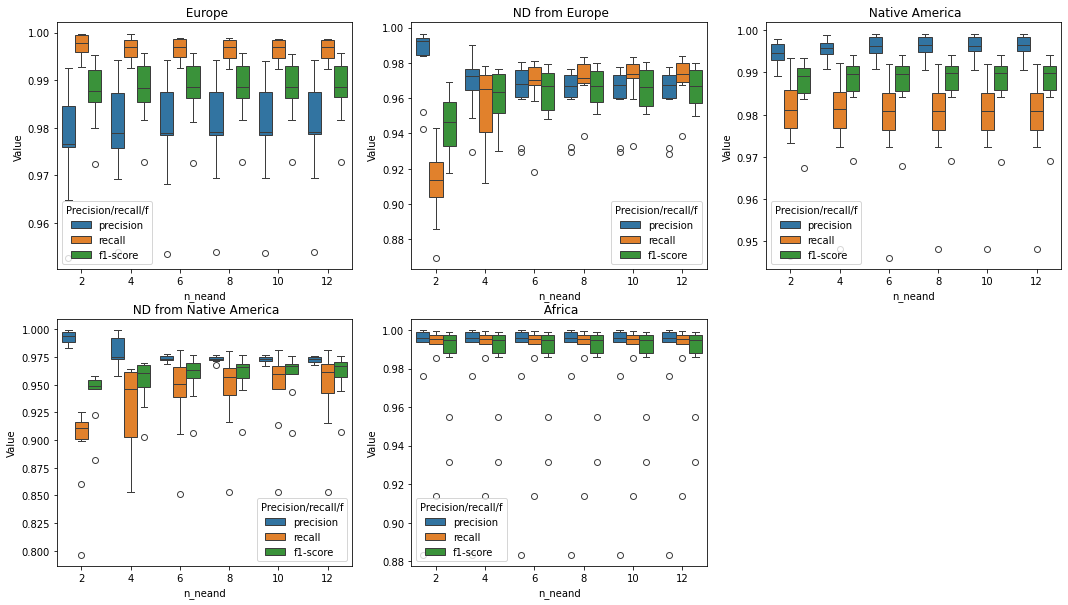

In [414]:
df_ND.to_csv('ND.dependency.L=1000.csv', encoding='utf-8',index=False)


df_ND_0 = df_ND[df_ND['State']==0 ]
df_ND_1 = df_ND[df_ND['State']==1] 
df_ND_2 = df_ND[df_ND['State']==2 ]
df_ND_3 = df_ND[df_ND['State']==3]
df_ND_4 = df_ND[df_ND['State']==4]


fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Pokemon Stats by Generation')
seaborn.boxplot(ax=axes[0, 0],data=df_ND_0, x="n_neand", y="Value", hue="Precision/recall/f").set_title(' Europe')
seaborn.boxplot(ax=axes[0, 1],data=df_ND_1, x="n_neand", y="Value", hue='Precision/recall/f').set_title(' ND from Europe')
seaborn.boxplot(ax=axes[0, 2], data=df_ND_2, x="n_neand", y="Value", hue="Precision/recall/f").set_title(' Native America')
seaborn.boxplot(ax=axes[1, 0], data=df_ND_3, x="n_neand", y="Value", hue="Precision/recall/f").set_title(' ND from Native America')
seaborn.boxplot(ax=axes[1, 1], data=df_ND_4, x="n_neand", y="Value", hue="Precision/recall/f").set_title(' Africa')

fig.delaxes(axes[1][2])
fig.suptitle('')
plt.savefig('ND.hapl.dependency.L=1000.png')

# We decrease number of NA haplotypes and fix neanderthals as 6

In [405]:
df_diff_NA_numbers = pd.DataFrame(columns=['State', 'Value', 'Precision/recall/f', 'Mex', 'n_neand', 'n_na_hapl'])
ind_list = list_mex_with_af_ancestry[0:10] 

cut = 1000
n_ref_pop = 250

A = initA(T[0], T[5], RR, cut, proportions[1], proportions[2], 0.05)
P = [0.4, 0.05, 0.4, 0.05, 0.1]

epsilon = 1e-10 #stop criterior for EM
seq_length = len_sequence

SEQ = []

number_NA = [50,  100,  150,  200, 250]
n_neanderthals = 6

for i in range(len(ind_list)):
    ind_number = (ind_list)[i]
    STATES = color_states(cut, tractsnd[i], tractseu[i], tractsas[i], tractsaf[i])
    
    seqEu = createSeqObs_main(TS,cut,'EU', ind_number,  num_mexicans, n, n_ref_pop )
    seqAf = createSeqObs_main(TS,cut,'AF', ind_number,  num_mexicans, n, n_ref_pop )
    seq_Nd = np.array(createSeqObs_neand(TS, cut, ind_number, n_neanderthals, num_mexicans, n, n_neand ))
    
    
    for n_na_hapl in number_NA: 
        seqNa = createSeqObs_main(TS,cut,'NA', ind_number,  num_mexicans, n, n_na_hapl )
        SEQ=np.column_stack((seqEu,seqNa,seqAf,seq_Nd))      
        number_states = max([max(seq_Nd), max(seqEu), max(seqNa), max(seqAf)])    

        LAMBDA_best = EM_algorithm(A, P, SEQ, number_states, MU, LAMBDA/2, epsilon) 
        B=initB(MU, cut, LAMBDA_best, number_states+1) 
        res = viterbi(SEQ, P, A, B)
        tracts = get_HMM_tracts(res)
        
        cl_report = classification_report(STATES, res,  digits=3, output_dict = True)
        
        for j in range(5):
            df_diff_NA_numbers.loc[len(df_diff_NA_numbers .index)] = [j, cl_report[str(j)]['precision'], 'precision',i, n_neanderthals,n_na_hapl]
            df_diff_NA_numbers.loc[len(df_diff_NA_numbers .index)] = [j, cl_report[str(j)]['recall'], 'recall',i, n_neanderthals,n_na_hapl]
            df_diff_NA_numbers.loc[len(df_diff_NA_numbers .index)] = [j, cl_report[str(j)]['f1-score'], 'f1-score',i, n_neanderthals,n_na_hapl]
    print(' Done one mex')


Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
 Done one mex
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
 Done one mex
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 8
 Done one mex
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
 Done one mex
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
 Done one mex
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 8
 Done one mex
Число шаго

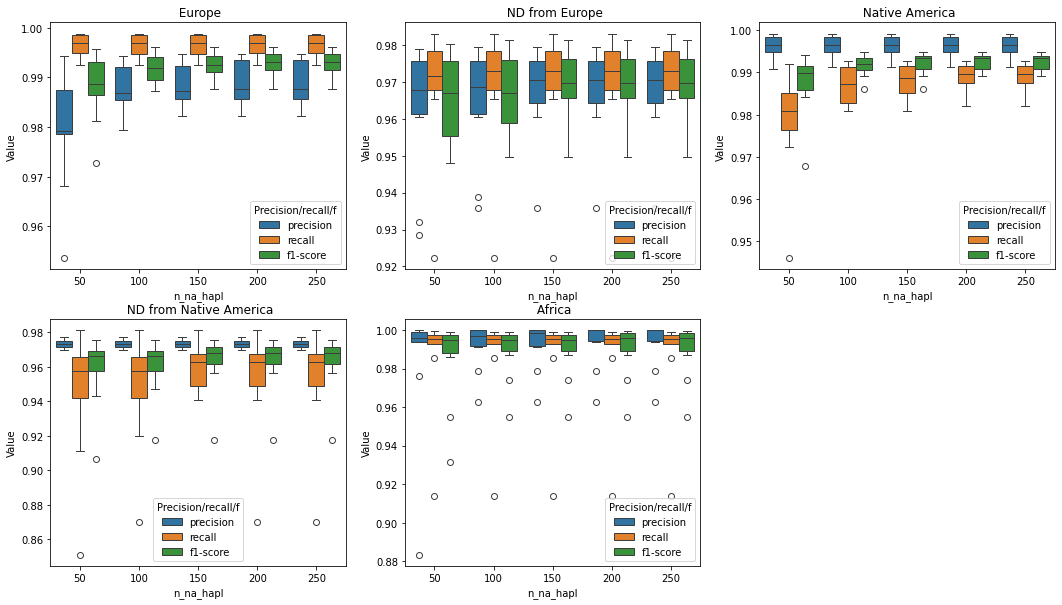

In [413]:
df_diff_NA_numbers.to_csv('NA.dependency.nd=6.csv', encoding='utf-8',index=False)
df_na=df_diff_NA_numbers

df_na_0 = df_na[df_na['State']==0 ]
df_na_1 = df_na[df_na['State']==1] 
df_na_2 = df_na[df_na['State']==2 ]
df_na_3 = df_na[df_na['State']==3]
df_na_4 = df_na[df_na['State']==4]


fig, axes = plt.subplots(2, 3, figsize=(18, 10))

fig.suptitle('Pokemon Stats by Generation')
seaborn.boxplot(ax=axes[0, 0],data=df_na_0, x="n_na_hapl", y="Value", hue="Precision/recall/f").set_title(' Europe')
seaborn.boxplot(ax=axes[0, 1],data=df_na_1, x="n_na_hapl", y="Value", hue='Precision/recall/f').set_title(' ND from Europe')
seaborn.boxplot(ax=axes[0, 2], data=df_na_2, x="n_na_hapl", y="Value", hue="Precision/recall/f").set_title(' Native America')
seaborn.boxplot(ax=axes[1, 0], data=df_na_3, x="n_na_hapl", y="Value", hue="Precision/recall/f").set_title(' ND from Native America')
seaborn.boxplot(ax=axes[1, 1], data=df_na_4, x="n_na_hapl", y="Value", hue="Precision/recall/f").set_title(' Africa')

fig.delaxes(axes[1][2])
fig.suptitle('')
plt.savefig('NA_hapl_dependency.nd=6.L=1000.png')

# L-dependency

In [407]:
df_L = pd.DataFrame(columns=['State', 'Value', 'Precision/recall/f', 'Mex', 'n_neand', 'L', 'n_na_hapl'])

list_L=[ 250, 500, 1000]
ind_list = list_mex_with_af_ancestry[0:10] 

n_ref_pop = 250
A = initA(T[0], T[5], RR, cut, proportions[1], proportions[2], 0.05)
P = [0.4, 0.05, 0.4, 0.05, 0.1]

epsilon = 1e-10 #stop criterior for EM
seq_length = len_sequence

SEQ = []

n_na_hapl = 50
n_neanderthals = 6

for i in range(len(ind_list)):
    ind_number = (ind_list)[i]
    
    for cut in list_L:
    
        STATES = color_states(cut, tractsnd[i], tractseu[i], tractsas[i], tractsaf[i])

        seqEu = createSeqObs_main(TS,cut,'EU', ind_number,  num_mexicans, n, n_ref_pop )
        seqAf = createSeqObs_main(TS,cut,'AF', ind_number,  num_mexicans, n, n_ref_pop )
        seq_Nd = np.array(createSeqObs_neand(TS, cut, ind_number, n_neanderthals, num_mexicans, n, n_neand ))
        seqNa = createSeqObs_main(TS,cut,'NA', ind_number,  num_mexicans, n, n_na_hapl )
        
        SEQ=np.column_stack((seqEu,seqNa,seqAf,seq_Nd))      
        number_states = max([max(seq_Nd), max(seqEu), max(seqNa), max(seqAf)])    

        LAMBDA_best = EM_algorithm(A, P, SEQ, number_states, MU, LAMBDA/2, epsilon)
        times_best = LAMBDA_best/ (2*MU*cut)    
        B=initB(MU, cut, LAMBDA_best, number_states+1) 
        res = viterbi(SEQ, P, A, B)
        tracts = get_HMM_tracts(res)

        cl_report = classification_report(STATES, res,  digits=3, output_dict = True)

        for j in range(5):
            df_L.loc[len(df_L .index)] = [j, cl_report[str(j)]['precision'], 'precision',i, n_neanderthals, cut, n_na_hapl]
            df_L.loc[len(df_L .index)] = [j, cl_report[str(j)]['recall'], 'recall',i, n_neanderthals, cut,n_na_hapl]
            df_L.loc[len(df_L .index)] = [j, cl_report[str(j)]['f1-score'], 'f1-score',i, n_neanderthals,cut,n_na_hapl]
    print(' Done')

Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 8
 Done
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
 Done
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 7
Число шагов в EM -алгоритме 9
 Done
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
 Done
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 9
 Done
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 7
 Done
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 9
 Done
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 9
 Done
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 10
 Done
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 8
Число шагов в EM -алгоритме 8
 Done


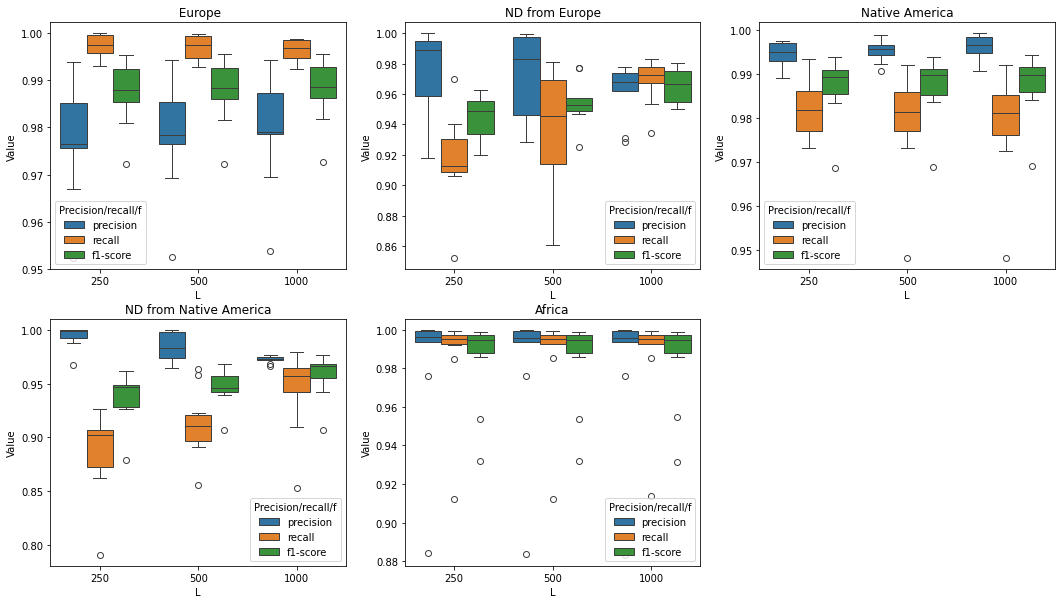

In [411]:
df_L.to_csv('L.dependency.csv', encoding='utf-8',index=False)


df_L_0 = df_L[df_L['State']==0 ]
df_L_1 = df_L[df_L['State']==1] 
df_L_2 = df_L[df_L['State']==2 ]
df_L_3 = df_L[df_L['State']==3]
df_L_4 = df_L[df_L['State']==4]


fig, axes = plt.subplots(2, 3, figsize=(18, 10))

#fig.suptitle('Pokemon Stats by Generation')
seaborn.boxplot(ax=axes[0, 0],data=df_L_0, x="L", y="Value", hue="Precision/recall/f").set_title(' Europe')
seaborn.boxplot(ax=axes[0, 1],data=df_L_1, x="L", y="Value", hue='Precision/recall/f').set_title('ND from Europe')
seaborn.boxplot(ax=axes[0, 2], data=df_L_2, x="L", y="Value", hue="Precision/recall/f").set_title('Native America')
seaborn.boxplot(ax=axes[1, 0], data=df_L_3, x="L", y="Value", hue="Precision/recall/f").set_title('ND from Native America')
seaborn.boxplot(ax=axes[1, 1], data=df_L_4, x="L", y="Value", hue="Precision/recall/f").set_title('Africa')

fig.delaxes(axes[1][2])
#fig.suptitle('')
plt.savefig('L.dependency.nd=6.png')

In [412]:
df_L

,State,Value,Precision/recall/f,Mex,n_neand,L,n_na_hapl
0,0,0.975466,precision,0,6,250,50
1,0,0.994314,recall,0,6,250,50
2,0,0.984800,f1-score,0,6,250,50
3,1,0.949769,precision,0,6,250,50
4,1,0.912739,recall,0,6,250,50
...,...,...,...,...,...,...,...
445,3,0.964081,recall,9,6,1000,50
446,3,0.968336,f1-score,9,6,1000,50
447,4,0.996603,precision,9,6,1000,50
448,4,0.993229,recall,9,6,1000,50


# Comparing with Skov. Get one mexican without african ancestry

In [29]:
ind_nimber_noaf_mas = [1,3,4,8]
tractsND_noaf,tractsEU_noaf, tractsAS_noaf,tractsAF_noaf=[],[],[],[]

for ind_number_noaf in ind_nimber_noaf_mas:

    tractsND_noaf.append(get_migrating_tracts_ind(TS, "NEAND", ind_number_noaf, T[0]))
    tractsEU_noaf.append(get_migrating_tracts_ind(TS,"EU", ind_number_noaf, T[5]))
    tractsAS_noaf.append( get_migrating_tracts_ind(TS,"NA", ind_number_noaf, T[5]))
    tractsAF_noaf.append(get_migrating_tracts_ind(TS,"AF", ind_number_noaf, T[5]))

In [64]:
cut=1000
STATES_noaf = [color_states(cut, tractsND_noaf[i] , tractsEU_noaf[i] , tractsAS_noaf[i], tractsAF_noaf[i]) 
               for i in range(4)]
STATES_noaf_01 = []
for j in range(4):
    s=[]
    for i in STATES_noaf[j]:
        if i in [1,3]:
            s.append(1)       
        else:
            s.append(0)
    STATES_noaf_01.append(s)

In [32]:
n_ref_pop=250
f_names = ['Skov.0.txt', 'Skov.1.txt', 'Skov.2.txt', 'Skov.3.txt', 'Skov.4.txt' ]
for i in range(4):
    with open(f_names[i], "w") as file:
        file.write("chrom  pos     ancestral_base  genotype\n")
        for v in TS.variants():

            flag= False
            for j in range(num_mexicans+2*n_ref_pop, num_mexicans+3*n_ref_pop):

                if abs(v.genotypes[ind_nimber_noaf_mas [i]]-v.genotypes[j]) == 0:
                    flag= True
                    break

            if flag==False:                
                file.write('chr1   '+str(int(v.position))+'    0               1\n')

IndexError: list index out of range

In [50]:
f2_names = ['Skov.0.ancestry.txt', 'Skov.1.ancestry.txt', 'Skov.2.ancestry.txt', 'Skov.3.ancestry.txt' ]
tracts_noaf = []
for j in range(4):
    with open(f2_names[j],'r') as f:
        lines = f.readlines()
    for i in range(len(lines)):
        lines[i] = lines[i].split('\t')
    lines2=[]    
    for i in range(len(lines)):
        if 'Archaic' in lines[i]:
            lines2.append(lines[i])

    tracts_noaf1 = []
    for i in range(len(lines2)):
        tracts_noaf1.append([int(lines2[i][1]), int(lines2[i][2])])
    
    tracts_noaf.append(tracts_noaf1)   

In [53]:
def point_in_interval(p, interval):
    if p >= interval[0] and p <= interval[1]:
        return True
    else:
        return False
    
seq_length = len_sequence    
cut=1000
Skov_ancestry=np.zeros((4,int(seq_length/cut)))
for k in range(4):
    for i in range(int(seq_length/cut)):
        for j in tracts_noaf[k]:
            if point_in_interval(i,[j[0]/cut, j[1]/cut])==True:
                Skov_ancestry[k,i]=1

In [105]:
df_Skov = pd.DataFrame(columns=['State', 'Value', 'Pr/rec/f1', 'Mex','Skov/me'])

for i in range(4):
    cl_report = classification_report(STATES_noaf_01[i],Skov_ancestry[i],  digits=3, output_dict = True)
    
    for j in range(2):
        df_Skov.loc[len(df_Skov .index)] = [j, cl_report[str(j)]['precision'],'precision', i, 'Skov']
        df_Skov.loc[len(df_Skov .index)] = [j,cl_report[str(j)]['recall'] ,'recall',i, 'Skov']
        df_Skov.loc[len(df_Skov .index)] = [j, cl_report[str(j)]['f1-score'], 'f1'  ,i, 'Skov']
    
df_Skov

,State,Value,Pr/rec/f1,Mex,Skov/me
0,0,0.996003,precision,0,Skov
1,0,0.989583,recall,0,Skov
2,0,0.992783,f1,0,Skov
3,1,0.785906,precision,0,Skov
4,1,0.905926,recall,0,Skov
5,1,0.841659,f1,0,Skov
6,0,0.996930,precision,1,Skov
7,0,0.992317,recall,1,Skov
8,0,0.994618,f1,1,Skov
9,1,0.817970,precision,1,Skov


In [69]:
n_neanderthals = 6
n_na_hapl=50

In [106]:
P = [0.4, 0.05, 0.4, 0.05, 0.1]
N=5
epsilon = 1e-10 #stop criterior for EM

Our_ancestry = []
for ind_number_noaf in ind_nimber_noaf_mas:

    seqEu = createSeqObs_main(TS,cut,'EU', ind_number_noaf,  num_mexicans, n, n_ref_pop )
    seqAf = createSeqObs_main(TS,cut,'AF', ind_number_noaf,  num_mexicans, n, n_ref_pop )
    seq_Nd = np.array(createSeqObs_neand(TS, cut, ind_number_noaf, n_neanderthals, num_mexicans, n, n_neand ))
    seqNa = createSeqObs_main(TS,cut,'NA', ind_number_noaf,  num_mexicans, n, n_na_hapl )

    SEQ=np.column_stack((seqEu,seqNa,seqAf,seq_Nd))      
    number_states = max([max(seq_Nd), max(seqEu), max(seqNa), max(seqAf)])    

    LAMBDA= 2 * MU * cut* np.array([T[0], T[1], T[2], T[3], T[5]])
    A = initA(T[0], T[5], RR, cut, proportions[1], proportions[2], 0.05)
    LAMBDA_best = EM_algorithm(A, P, SEQ, number_states, MU, LAMBDA/2, epsilon)
    B=initB(MU, cut, LAMBDA_best, number_states+1) 
    res = viterbi(SEQ, P, A, B)


    res2 = []
    for i in res:
        if i in [1,3]:        
            res2.append(1)
        else:        
            res2.append(0)  
    Our_ancestry.append(res2)
    
for i in range(len(ind_nimber_noaf_mas)):    
    cl_report = classification_report(STATES_noaf_01[i],Our_ancestry[i],  digits=3, output_dict = True)

    
    for j in range(2):
        df_Skov.loc[len(df_Skov .index)] = [j, cl_report[str(j)]['precision'],'precision', i, 'Me']
        df_Skov.loc[len(df_Skov .index)] = [j,cl_report[str(j)]['recall'] ,'recall',i, 'Me']
        df_Skov.loc[len(df_Skov .index)] = [j, cl_report[str(j)]['f1-score'], 'f1'  ,i, 'Me']


Число шагов в EM -алгоритме 11
Число шагов в EM -алгоритме 10
Число шагов в EM -алгоритме 9
Число шагов в EM -алгоритме 8


In [108]:
df_Skov.to_csv('Skov.csv', encoding='utf-8',index=False)
df_Skov

,State,Value,Pr/rec/f1,Mex,Skov/me
0,0,0.996003,precision,0,Skov
1,0,0.989583,recall,0,Skov
2,0,0.992783,f1,0,Skov
3,1,0.785906,precision,0,Skov
4,1,0.905926,recall,0,Skov
5,1,0.841659,f1,0,Skov
6,0,0.996930,precision,1,Skov
7,0,0.992317,recall,1,Skov
8,0,0.994618,f1,1,Skov
9,1,0.817970,precision,1,Skov


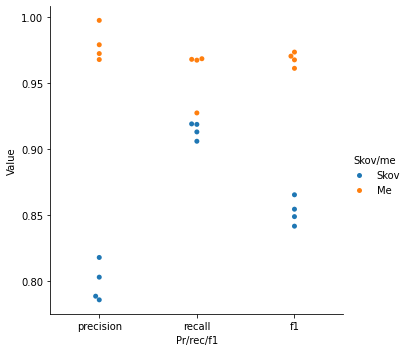

In [113]:
seaborn.catplot(data=df_Skov[df_Skov['State']==1], x="Pr/rec/f1", y="Value", hue="Skov/me", kind="swarm")

In [ ]:
def intersections(a,b):
    ranges = []
    i = j = 0
    while i < len(a) and j < len(b):
        a_left, a_right = a[i]
        b_left, b_right = b[j]

        if a_right < b_right:
            i += 1
        else:
            j += 1

        if a_right >= b_left and b_right >= a_left:
            end_pts = sorted([a_left, a_right, b_left, b_right])
            middle = [end_pts[1], end_pts[2]]
            ranges.append(middle)

    ri = 0
    while ri < len(ranges)-1:
        if ranges[ri][1] == ranges[ri+1][0]:
            ranges[ri:ri+2] = [[ranges[ri][0], ranges[ri+1][1]]]

        ri += 1

    return ranges

a = [[0,2], [5,10], [13,23], [24,25]]
b = [[1,5], [8,12], [15,18], [20,24]]
print(intersections(a,b))
# [[1, 2], [5, 5], [8, 10], [15, 18], [20, 24]]

# Numerical optimization of Q

# One estiomation of parameters for many individuals

In [289]:


def Q_function2(lmbd):
    
    lmbd=np.array(lmbd)
    Q = 0
    A = initA(lmbd[0]/d, lmbd[4]/d, RR , cut, 0.5, 0.45, 0.05)
    b = initB(MU, cut, lmbd[0:5],  number_states+1)
    
    for i in range(N):
        for j in range(N):
            Q += math.log(A[i,j]) * coeff_a[i,j]

    for i in range(N):
        for t in range(len(seq)):
            Q += math.log ( b[i, seq[t][0],seq[t][1],seq[t][2],seq[t][3]]) * gamma[i,t]
    return -Q

def multi_Q(lmbd):
    
    lmbd=np.array(lmbd)
    Q = 0
    A = initA(lmbd[0]/d, lmbd[4]/d, RR , cut, 0.5, 0.45, 0.05)
    b = initB(MU, cut, lmbd[0:5],  number_states+1)
    
    for k in range(num_observed_mex):
        for i in range(N):
            for j in range(N):
                Q += math.log(A[i,j]) * COEFF_a[k,i,j]

        for i in range(N):
            for t in range(len(seq)):
                Q += math.log ( b[i, seq[k][t][0],seq[k][t][1],seq[k][t][2],seq[k][t][3]]) * GAMMA[k,i,t]
    return -Q

def gradient_respecting_bounds(bounds, fun, eps=1e-8):
    """bounds: list of tuples (lower, upper)"""
    def gradient(x):
        fx = fun(x)
        grad = np.zeros(len(x))
        for k in range(len(x)):
            d = np.zeros(len(x))
            d[k] = eps if x[k] + eps <= bounds[k][1] else -eps
            grad[k] = (fun(x + d) - fx) / d[k]
        return grad
    return gradient


seq = [] 
number_states = 0
num_observed_mex = 10
for i in range(num_observed_mex):
    ind_number = list(list_mex_with_af_ancestry)[i]
    seqEu = createSeqObs_main(TS,cut,'EU', ind_number,  num_mexicans, n, n_ref_pop )
    seqNa = createSeqObs_main(TS,cut,'NA', ind_number,  num_mexicans, n, n_ref_pop  )
    seqAf = createSeqObs_main(TS,cut,'AF', ind_number,  num_mexicans, n, n_ref_pop )
    seqND = np.array(createSeqObs_neand(TS, cut, ind_number, n_neanderthals, num_mexicans, n, n_neand ))

    
    if number_states < max([max(seqND), max(seqEu), max(seqNa), max(seqAf)]) :
        number_states = max([max(seqND), max(seqEu), max(seqNa), max(seqAf)])
    
    seq.append(np.column_stack((seqEu,seqNa,seqAf,seqND)))
seq = np.array(seq)



In [290]:
bnds = ((d*T[0], d*(T[0]+10000/29)), (d*T[1], d*(T[1]+100000/29)), 
         (d*T[2], d*(T[2]+50000/29)),( d*T[3], d*(T[3]+20000/29)), (d*T[5], d*(T[5]+1000/29)))

lmbd_0 = np.zeros(5)
lmbd_0[0:5]= 2 * MU * cut* np.array([T[0]+1000, T[1]+10000, T[2], T[3], T[5]+50])
d = 2 * MU * cut
n_step = 10
for i in range(n_step):
    print(i)
    A_0 = initA(lmbd_0[0]/d, lmbd_0[4]/d, RR , cut, 0.5, 0.45, 0.05)  
    b_0 = initB(MU, cut, lmbd_0[0:5],  number_states+1)
    
    ALPHA, SC_FACTORS, BETA, GAMMA, KSI, COEFF_a  = [],[], [], [], [], []
    for i in range(num_observed_mex):
        alpha, sc_factors = alpha_scaled_opt(A_0,b_0, seq[i], P)
        beta = beta_scaled_opt(A_0, b_0, seq[i], sc_factors)    
        gamma = def_gamma(alpha, beta)
        ks = def_ksi( A_0, b_0, seq[i], alpha, beta)

        coeff_a = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                for t in range(len(seq)-1):
                    coeff_a[i, j] += ks[i, j, t] 
        ALPHA.append(alpha)
        BETA.append(beta)
        GAMMA.append(gamma)
        SC_FACTORS.append(sc_factors)
        COEFF_a.append(coeff_a)
        
    GAMMA = np.array(GAMMA)
    COEFF_a = np.array(COEFF_a)
        
    opt_result = scipy.optimize.minimize(multi_Q, lmbd_0, bounds=bnds, method="L-BFGS-B", jac=gradient_respecting_bounds(bnds, multi_Q),
                                        )
    print(opt_result.x[0:5]/d)
    
    if LNG.norm(lmbd_0-opt_result.x) < 1e-8:
        break
    else:
        lmbd_0[0:5] = opt_result.x[0:5]

0
[ 1724.13793103 25196.45933337  2482.75862069  1448.17241379
    51.72413793]
1
[ 1724.13793103 25198.11864709  2482.75862069  1448.17241379
    51.72413793]
2
[ 1724.13793103 25198.11762854  2482.75862069  1448.17241379
    51.72413793]
3
[ 1724.13793103 25198.11762854  2482.75862069  1448.17241379
    51.72413793]


In [293]:
opt_result.x[0:5]/d

array([ 1724.13793103, 25198.11762854,  2482.75862069,  1448.17241379,
          51.72413793])

In [292]:
A = initA(opt_result.x[0]/d, opt_result.x[4]/d, RR, cut, 0.5, 0.45, 0.05)
P = [0.4, 0.05, 0.4, 0.05, 0.1]    
B=initB(MU, cut, opt_result.x[0:5], number_states+1) 

for i in range(num_observed_mex):
    


    STATES = color_states(cut, tractsnd[i], tractseu[i], tractsna[i], tractsaf[i])
    res = viterbi(seq[i], P, A, B)
    print(sklearn.metrics.classification_report(STATES, res,  digits=3))


              precision    recall  f1-score   support

           0      0.998     0.982     0.990     76942
           1      0.962     0.971     0.967      4176
           2      0.988     0.999     0.993    107380
           3      0.979     0.958     0.968      3428
           4      1.000     0.998     0.999      8074

    accuracy                          0.991    200000
   macro avg      0.985     0.982     0.983    200000
weighted avg      0.991     0.991     0.991    200000

              precision    recall  f1-score   support

           0      0.997     0.993     0.995    111679
           1      0.970     0.969     0.970      3841
           2      0.991     0.997     0.994     59729
           3      0.975     0.982     0.979      2553
           4      0.994     0.995     0.994     22198

    accuracy                          0.994    200000
   macro avg      0.985     0.987     0.986    200000
weighted avg      0.994     0.994     0.994    200000

              precisio

2